## **Import Libraries**
___
Read in the required libraries.

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import seaborn as sns

import missingno as msno 
from typing import Optional

from scipy.stats import kurtosis, skew, shapiro
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


## **Read Files**
___
Read in the files that will be needed and set options for the visualization of dataframes.

In [157]:
# Read in file
df = pd.read_excel('Data/Online Retail.xlsx')

# Set max columns to be returned
pd.set_option('display.max_columns', None)

# Set the style of the plots
plt.style.use('ggplot')
# Set default colormap for continuous data (both Matplotlib and Seaborn)
plt.rcParams['image.cmap'] = 'mako'
# Set default palette for categorical data
sns.set_palette('mako')

## **Dataset Identification**
___
Identify the shape and size of the dataset along with its axes and datatypes for each feature to understand the overall structure of the dataset that has been read in.

In [158]:
# Return the shape of the dataset
shape = df.shape
print(f'Total number of rows: {shape[0]}\nTotal number of features: {shape[1]}')

Total number of rows: 541909
Total number of features: 8


In [159]:
# Return the total number of values in the dataset
df.size

4335272

In [160]:
# Return the index range and the feature names
df.axes

[RangeIndex(start=0, stop=541909, step=1),
 Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
        'UnitPrice', 'CustomerID', 'Country'],
       dtype='object')]

In [161]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [162]:
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [163]:
# Return the data typrers of each feature in the dataset
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

## **Dataset Preprocessing**
___


### 1. **Dataset Cleaning**

The data cleaning process is an essential step during data preprocessing, as it helps ensure the quality and consistency of the dataset for analysis or model training

#### 1.1 **Miscellaneous Data Errors**
These errors can be generalized as the errors found in the data values of the records in the dataframe. This step includes converting features to correct datatypes.

In [164]:
# Return the numeric feature in the dataset
df.select_dtypes(include='number')

,Quantity,UnitPrice,CustomerID
0,6,2.55,17850.0
1,6,3.39,17850.0
2,8,2.75,17850.0
3,6,3.39,17850.0
4,6,3.39,17850.0
...,...,...,...
541904,12,0.85,12680.0
541905,6,2.10,12680.0
541906,4,4.15,12680.0
541907,4,4.15,12680.0


In [165]:
# Return the categorical features in the dataset
df.select_dtypes(exclude=['number', 'datetime64'])

,InvoiceNo,StockCode,Description,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom
...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,France


##### 1.1.1 **InvoiceNo Feature**
Based on the data source [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/352/online+retail). InvoiceNo feature needs to be identified as a numeric feature. We need to find out why it has not been identified as a numeric feature.

In [166]:
# For the values in the feature that have alphanumeric data, remove the numeric values
alpha_char = df['InvoiceNo'].replace(r'[\d\s]', '', regex=True)

# For each value in the feature, check if the value is a string. Return the value counts of the 
# remaining values
alpha_char[alpha_char.apply(lambda x: isinstance(x, str))].value_counts()

InvoiceNo
C    9288
A       3
Name: count, dtype: int64

In [167]:
# Store a subset of the dataset with the the values with C in the beginning
invoice_with_c = df[df['InvoiceNo'].str.match('^C') == True]
invoice_with_c.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


In [168]:
# Store a subset of the dataset with the the values with A in the beginning
invoice_with_a = df[df['InvoiceNo'].str.match('^A') == True]
invoice_with_a

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299982,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,NaN,United Kingdom
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


In [169]:
# Return a dataframe with all the values with C or A in their invoice number.
alphanumeric_invoice = df[df['InvoiceNo'].str.match(r'[^\d\s]') == True]
alphanumeric_invoice

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


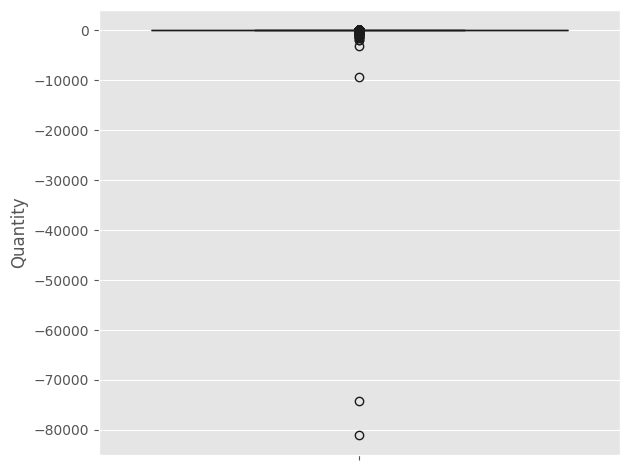

In [170]:
# Virsualise the dispersion of the Quantity feature of the invoice_with_c
sns.boxplot(invoice_with_c['Quantity'])
plt.tight_layout()
plt.show()

`NOTES:`

* When taking a deeper look at the InvoiceNo feature, we can see that the feature has some values that are alphanumeric, when the numeric characters were removed and the feature was filtered to only have string values, it was found that the remaining string values were the characters 'A' and 'C'. When particularly looking at the records with C character in the InvoiceNo value, it was found that all the values in the quantity feature were negative. This can be seen in the boxplot that was used to plot the dispersion of the field when the dataset was filtered to only contain values with C character in the InvoiceNo feature. 

* When looking at the data source at [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/352/online+retail), it can be seen through the feature description that, '*If this code starts with letter 'c', it indicates a cancellation*'. Therefore, because these records also have negative values in the Quantity feature, it makes sense to remove the records with a C-number in the InvoiceNo feature, to bring normalcy to the Quantity feature as well.

* The records with A-number value InvoiceNo feature, when isolated and returned as a dataframe, look to represent records that were recorded as bad debt. These records can also be removed because these records represent incomplete records as there are also nan values for the CustomerID field for these records. 

In [171]:
# Copy the dataframe
df2 = df.copy()

# Remove the values with the C-numbers and the A-numbers in the InvoiceNo record from the dataset. 
df2.drop(index=alphanumeric_invoice.index, axis=0, inplace=True)

# Reset the index of the processed dataset
df2 = df2.reset_index(drop=True)

In [172]:
print(
    f'Original dataframe: {df.shape}\nProcessed dataframe: {df2.shape}\n'
    f'Total values dropped: {df.shape[0] - df2.shape[0]}'
)

Original dataframe: (541909, 8)
Processed dataframe: (532618, 8)
Total values dropped: 9291


In [173]:
# Confirm that the remaining values in the feature are 6 characters in length
df2['InvoiceNo'].astype('str').apply(lambda x: len(x)).value_counts()

InvoiceNo
6    532618
Name: count, dtype: int64

#### 1.2 **Duplicated Values**
In the context of a dataframe, a record can be a duplicate of another record, if all the data values of each feature are identical. A record can also be considered a duplicate if the data values of a specified subset of features are identical. In this section, we look to identify and remove the duplicate values within the dataset.

In [174]:
# Return the total numbe of duplicated values in the dataset
dupes = df2.duplicated().sum()
print(f'The total number of duplicates in the dataset: {dupes}')

The total number of duplicates in the dataset: 5231


In [175]:
# Return a dataset of the duplicated values
df2[df2.duplicated(keep=False)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
476,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom
480,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom
485,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
508,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
512,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908.0,United Kingdom
...,...,...,...,...,...,...,...,...
532387,581538,22068,BLACK PIRATE TREASURE CHEST,1,2011-12-09 11:34:00,0.39,14446.0,United Kingdom
532401,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,2011-12-09 11:34:00,2.49,14446.0,United Kingdom
532404,581538,22992,REVOLVER WOODEN RULER,1,2011-12-09 11:34:00,1.95,14446.0,United Kingdom
532411,581538,22694,WICKER STAR,1,2011-12-09 11:34:00,2.10,14446.0,United Kingdom


In [176]:
# Create a duplicate of the dataframe
df3 = df2.copy()

# Drop the duplicated values within the dataset
df3.drop_duplicates(keep='first', ignore_index=True, inplace=True)

In [177]:
# Confirm if the duplicated values have been removed
dupes = df3.duplicated().sum()
print(f'The total number of duplicates in the dataset: {dupes}')

The total number of duplicates in the dataset: 0


#### 1.3 **Null Values**
Null values are missing data values within a feature of record. These missing values need to be identified and either removed or imputed. 

In [178]:
# Return the total number of null values in the dataset
nulls = np.count_nonzero(df3.isnull().values)
print(f'Total number of null values in the dataset: {nulls}')

Total number of null values in the dataset: 136109


In [179]:
# Check which columns have null values as a percentage
df3.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     134655
Country             0
dtype: int64

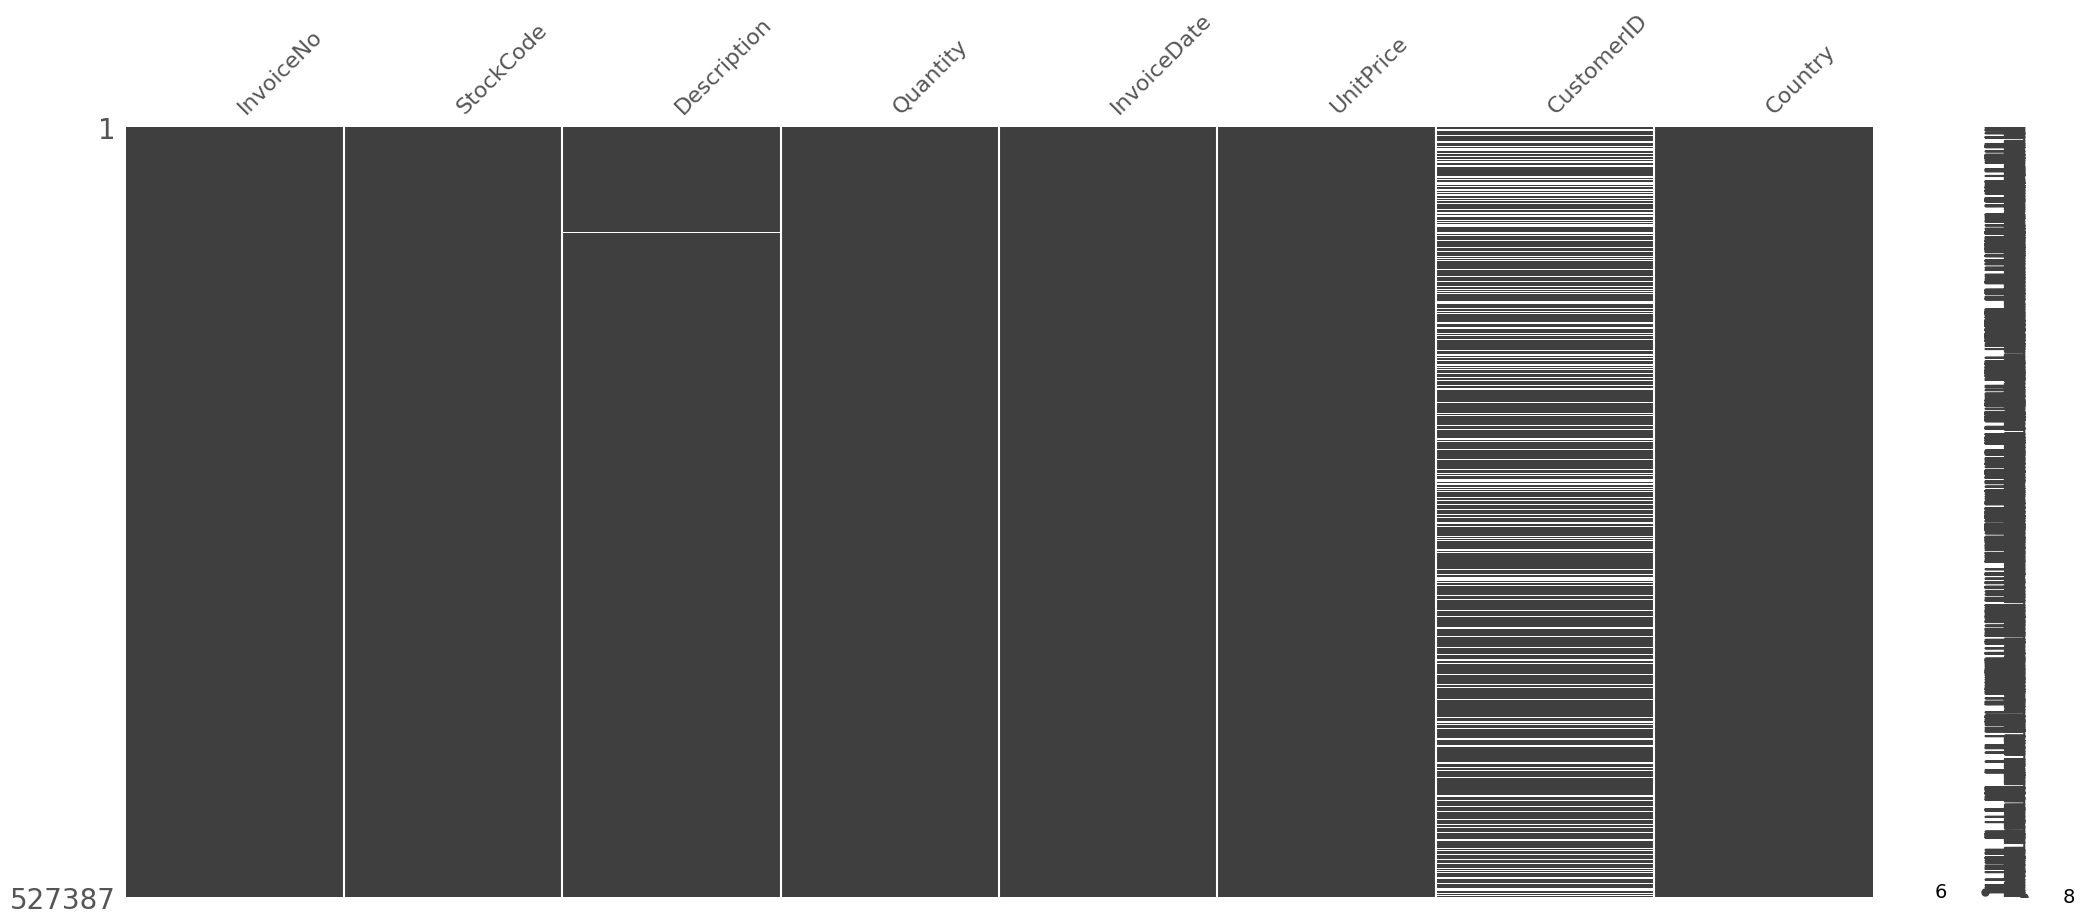

In [180]:
# Visualize the null values constituency in each feature
msno.matrix(df3)
plt.show()

In [181]:
# Return a subset of the dataset where the CustomerID value is null
df3[df3['CustomerID'].isnull().values]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
596,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom
1395,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1396,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1397,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom
1398,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
527025,581498,85099B,JUMBO BAG RED RETROSPOT,5,2011-12-09 10:26:00,4.13,NaN,United Kingdom
527026,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,2011-12-09 10:26:00,4.13,NaN,United Kingdom
527027,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,2011-12-09 10:26:00,4.96,NaN,United Kingdom
527028,581498,85174,S/4 CACTI CANDLES,1,2011-12-09 10:26:00,10.79,NaN,United Kingdom


In [182]:
# Create a copy of the dataset
df4 = df3.copy()

# Drop the nan values in the CustomerID feature
df4.dropna(subset='CustomerID', axis=0, inplace=True)

# Confirm whether the null values have been dropped from the CustomerID feature, and how it affects the rest of the null values in the dataframe
df4.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

#### 1.4 **Feature Engineering**
The process of adding features that will have a stronger correlation to the target variable, compared to the features that make up the engineered feature. 

`NOTES`:

* The aim of the report is to segment customers into different categorical clusters, and to make inferences and suggestions as to how to market and target to particular segments more effectively and efficiently to increase the bottom line of increasing profit margins. In an artical on recency, frequency, monetary segmentation on Optimove site (RMF), RMF Segmentation is defined as a marketing analysis method that involves analyzing customer behavior based on three key factors: recency, frequency, and monetary value. This RFM analysis helps businesses categorize customers into segments, enabling targeted and personalized marketing strategies. (Optimove, no date)

* To achieve RMF Segmentation, featurees need to be created, namely, Recency feature where the values describe the total number of days from a particular day the customer last made their last purchase. Monetary feature will be the total monetary contributions from the particular customer with all their transactions from the dataset. Finally, we will also create a Frequency feature which will aggregate the total number of purchases made by each customer. 

In [183]:
df4.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [184]:
# Create a copy of the dataframe
df5 = df4.copy()

# Add a total line sales to return the total sales value for each transaction
df5['TotalLineSales'] = df5['Quantity'] * df5['UnitPrice']
df5.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalLineSales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [185]:
# Return the total number of unique customers in the dataset
nunique_cust = df5['CustomerID'].nunique()
print(f'Total number of unique customers from the dataset: {nunique_cust}')

Total number of unique customers from the dataset: 4339


In [186]:
# Create a dataframe that will return the total monetary value, the recency of previous purchase, and total 
# count of purchases made by each unique customer in the dataset
aggregated_df = (
    df5.groupby('CustomerID', as_index=False)\
       .agg(
           MonetaryValue=('TotalLineSales', 'sum'),
           Frequency=('InvoiceNo', 'nunique'),
           LastInvoiceDate=('InvoiceDate', 'max')
       )
)

aggregated_df

,CustomerID,MonetaryValue,Frequency,LastInvoiceDate
0,12346.0,77183.60,1,2011-01-18 10:01:00
1,12347.0,4310.00,7,2011-12-07 15:52:00
2,12348.0,1797.24,4,2011-09-25 13:13:00
3,12349.0,1757.55,1,2011-11-21 09:51:00
4,12350.0,334.40,1,2011-02-02 16:01:00
...,...,...,...,...
4334,18280.0,180.60,1,2011-03-07 09:52:00
4335,18281.0,80.82,1,2011-06-12 10:53:00
4336,18282.0,178.05,2,2011-12-02 11:43:00
4337,18283.0,2045.53,16,2011-12-06 12:02:00


In [187]:
# Take the last recorded date as the point of reference to determine number of days since last transaction
last_transaction_date = aggregated_df['LastInvoiceDate'].max()

# Add a new column into the aggregated dataframe for the recency of last transaction
aggregated_df['Recency'] = (last_transaction_date - aggregated_df['LastInvoiceDate']).dt.days
aggregated_df

,CustomerID,MonetaryValue,Frequency,LastInvoiceDate,Recency
0,12346.0,77183.60,1,2011-01-18 10:01:00,325
1,12347.0,4310.00,7,2011-12-07 15:52:00,1
2,12348.0,1797.24,4,2011-09-25 13:13:00,74
3,12349.0,1757.55,1,2011-11-21 09:51:00,18
4,12350.0,334.40,1,2011-02-02 16:01:00,309
...,...,...,...,...,...
4334,18280.0,180.60,1,2011-03-07 09:52:00,277
4335,18281.0,80.82,1,2011-06-12 10:53:00,180
4336,18282.0,178.05,2,2011-12-02 11:43:00,7
4337,18283.0,2045.53,16,2011-12-06 12:02:00,3


#### 1.5 **Outlier Values**
An outlier is a data point that differs significantly from other observations in a dataset. Outliers can occur due to variability in the data or errors in measurement, and they can influence the results of statistical analyses and machine learning models.

In [188]:
def boxplotOutliers(dataframe: pd.DataFrame):
    plt.figure(figsize=(14, 6))

    dataframe_subset = dataframe.select_dtypes(exclude='datetime64').drop(columns='CustomerID')
    for i, column in enumerate(dataframe_subset):
        plt.subplot(1, 3, i + 1)
        sns.boxplot(dataframe[column], orient='h')
        plt.title(f'{column}')

    plt.tight_layout()
    plt.show()

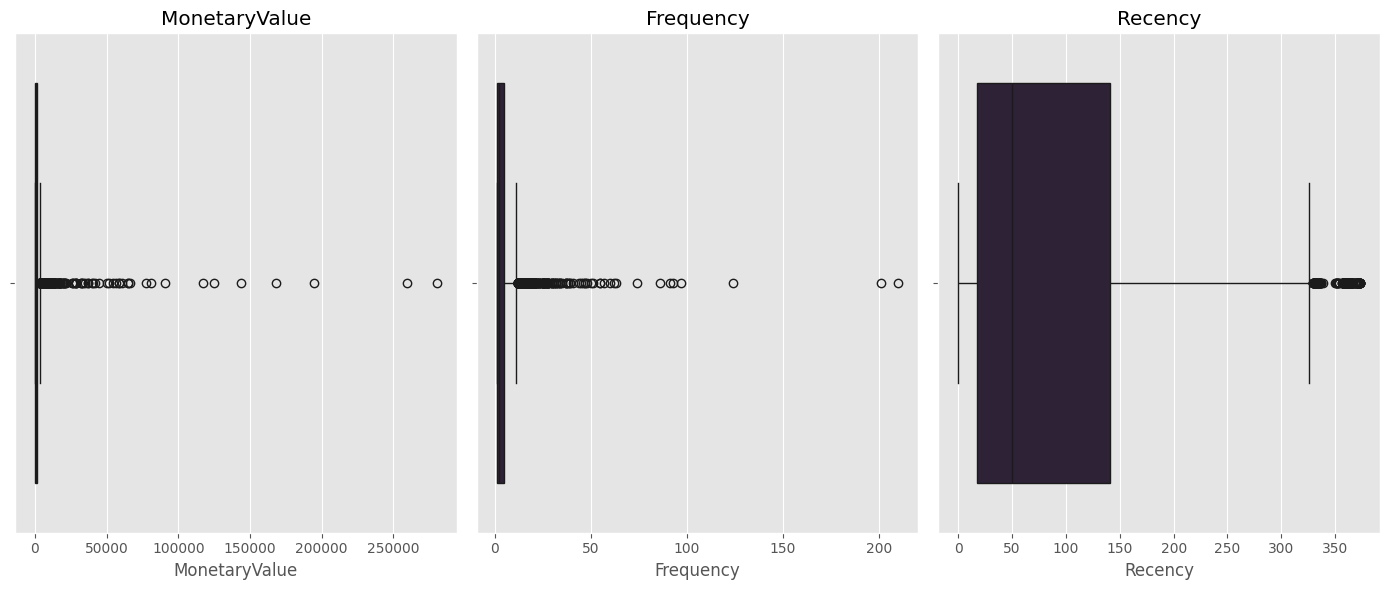

In [189]:
# Visualize the disperson of each feature in the aggregated_df
boxplotOutliers(aggregated_df)

In [190]:
def outlierIQR(column: str, output: Optional[bool]=True,
               return_dataframe: Optional[bool]=False, dataframe: Optional[pd.DataFrame]=aggregated_df):
    # Find the first and third quantile values
    q1 = dataframe[column].quantile(0.25)
    q3 = dataframe[column].quantile(0.75)

    # Store the IQR value 
    IQR = q3 - q1 

    # Store the upper and lower limits as masks
    upper = dataframe[column] > q3 + (IQR * 1.5)
    lower = dataframe[column] < q1 - (IQR * 1.5)

    # Store the outlier values
    outliers = dataframe[column][upper | lower]

    if (len(outliers) > 0) & (output == True):
        print(f'{column} feature has {len(outliers)} outliers\n')

        return outliers.index.to_list()
    
    if return_dataframe == True:
        return dataframe.loc[outliers.index, :]

In [191]:
outliers = []
for column in aggregated_df.select_dtypes(exclude='datetime64').drop(columns='CustomerID'):
    feature_outlier_index = outlierIQR(column)
    outliers.append(feature_outlier_index)

# Flatten the list using list comprehension
outliers_flattened = [element for sublist in outliers for element in sublist]

MonetaryValue feature has 425 outliers

Frequency feature has 285 outliers

Recency feature has 155 outliers



In [192]:
# Store a dataframe of non-outlier values
non_outlier_df = aggregated_df.drop(index=outliers_flattened)
non_outlier_df

,CustomerID,MonetaryValue,Frequency,LastInvoiceDate,Recency
2,12348.0,1797.24,4,2011-09-25 13:13:00,74
3,12349.0,1757.55,1,2011-11-21 09:51:00,18
4,12350.0,334.40,1,2011-02-02 16:01:00,309
5,12352.0,2506.04,8,2011-11-03 14:37:00,35
6,12353.0,89.00,1,2011-05-19 17:47:00,203
...,...,...,...,...,...
4333,18278.0,173.90,1,2011-09-27 11:58:00,73
4334,18280.0,180.60,1,2011-03-07 09:52:00,277
4335,18281.0,80.82,1,2011-06-12 10:53:00,180
4336,18282.0,178.05,2,2011-12-02 11:43:00,7


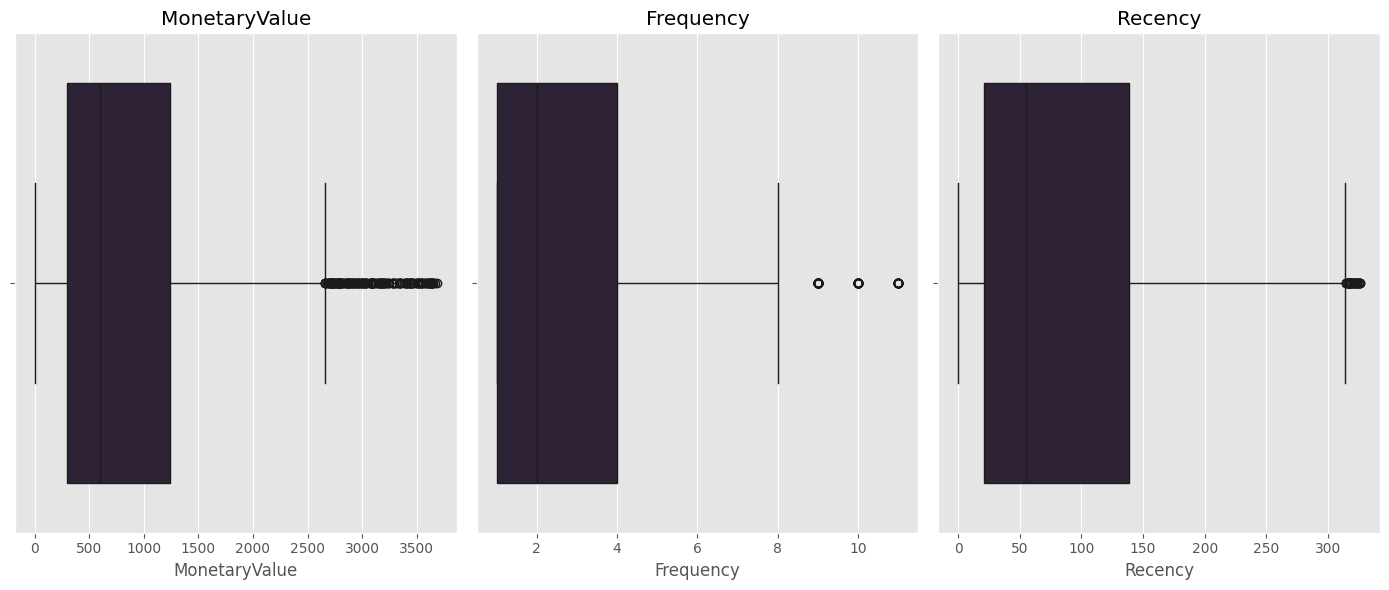

In [193]:
boxplotOutliers(non_outlier_df)

In [194]:
# Store a dataframe of outlier values
outlier_df = aggregated_df.loc[outliers_flattened, :]
outlier_df

,CustomerID,MonetaryValue,Frequency,LastInvoiceDate,Recency
0,12346.0,77183.60,1,2011-01-18 10:01:00,325
1,12347.0,4310.00,7,2011-12-07 15:52:00,1
10,12357.0,6207.67,1,2011-11-06 16:07:00,32
12,12359.0,6310.03,4,2011-10-13 12:47:00,57
15,12362.0,5226.23,10,2011-12-06 15:40:00,2
...,...,...,...,...,...
4205,18106.0,421.90,1,2011-01-14 12:23:00,329
4210,18113.0,76.32,1,2010-12-06 12:31:00,368
4215,18119.0,180.70,1,2010-12-07 11:59:00,367
4256,18176.0,476.35,1,2010-12-16 15:45:00,357


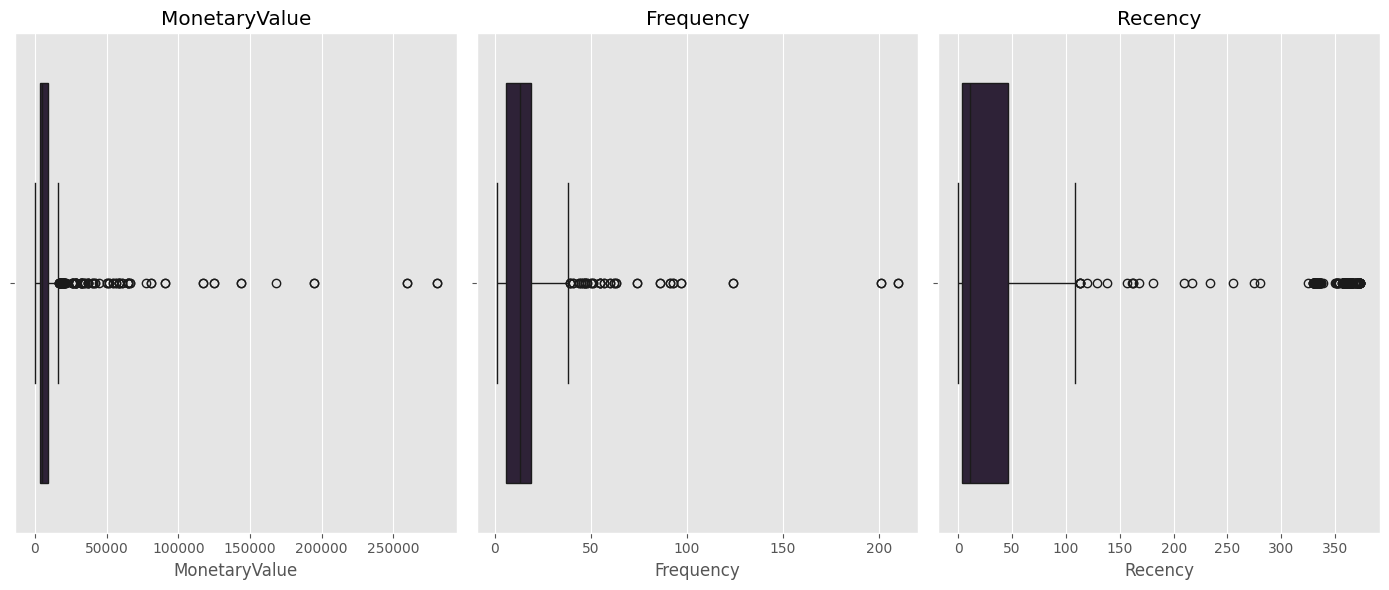

In [195]:
boxplotOutliers(outlier_df)

#### 1.6 **Further Data Exploration**

In [196]:
# Look at the summary descriptive statistics of the outlier_df
outlier_df.describe()

,CustomerID,MonetaryValue,Frequency,LastInvoiceDate,Recency
count,865.000000,865.000000,865.000000,865,865.000000
mean,15171.682081,11124.253561,16.048555,2011-09-19 22:40:44.115607040,80.124855
min,12346.000000,15.000000,1.000000,2010-12-01 09:53:00,0.000000
25%,13523.000000,3722.820000,6.000000,2011-10-24 11:51:00,3.000000
50%,15180.000000,5180.520000,13.000000,2011-11-27 13:00:00,11.000000
75%,16717.000000,8778.820000,19.000000,2011-12-06 10:28:00,46.000000
max,18283.000000,280206.020000,210.000000,2011-12-09 12:49:00,373.000000
std,1802.544479,25738.446602,19.680608,NaN,134.605788


In [197]:
# Look at the summary descriptive statistics of the non_outlier_df
non_outlier_df.describe()

,CustomerID,MonetaryValue,Frequency,LastInvoiceDate,Recency
count,3711.000000,3711.000000,3711.000000,3711,3711.000000
mean,15326.571005,882.969128,2.834276,2011-09-10 19:21:09.248180992,89.208030
min,12348.000000,0.000000,1.000000,2011-01-17 10:52:00,0.000000
25%,13859.500000,292.785000,1.000000,2011-07-23 13:19:30,21.000000
50%,15329.000000,598.830000,2.000000,2011-10-14 16:05:00,55.000000
75%,16798.000000,1238.925000,4.000000,2011-11-18 10:34:00,138.500000
max,18287.000000,3683.860000,11.000000,2011-12-09 12:50:00,326.000000
std,1702.055585,810.856688,2.190095,NaN,88.966049


`NOTES`:

* A further investigation into why the minimum value of the MonetaryValue feature is 0. There should be no transaction that was for free. 

In [198]:
# Filter the non_outlier_df to a subset which includes records with values that are 0
non_outlier_df[non_outlier_df['MonetaryValue'] == 0]

,CustomerID,MonetaryValue,Frequency,LastInvoiceDate,Recency
685,13256.0,0.0,1,2011-11-25 15:57:00,13


In [199]:
# Remove record 542
non_outlier_df.drop(index=non_outlier_df[non_outlier_df['MonetaryValue'] == 0].index, inplace=True)

#### `PRE-PROCESSING SUMMARY`

1. **Dropped Records**
    * There were a total of *9291* records with a C-number or an A-number for a values in the InvoiceNo feature. The C-number records represented cancelled transactions and therefore should be removed from the dataset. The A-number values represent bad debt and had nan values in the CustomerID feature, which cannot have nan values as the feature will be required for further analysis of customer patterns. 
    
    * In total there are a total of *9288* C-number values in the dataset, and *3* A-number feature.

2. **Duplicated Values**: 
    * There are a total of *5268* duplicated values in the dataset.
    
    * Removed the duplicated values

3. **Null Values**
    * Initially, we had a total of *136109* null values in the dataset. 

    * The features with the null values include: Description (1454 null values) and CustomerID (134655 null values) features

    * The purpose of the analysis to come is to cluster our customers using the grouped values for each customer id in the dataset. We do not have enough information to infer the CustomerID values.

    * Once the null values in the CustomerID features have been dropped, there were no longer any null values in the dataset, suggesting that where there was a null value for CustomerID feature, there were also na values in some records for Description feature. 

    * In total, *136109* features have been dropped from the dataset.

4. **Feature Engineering**
    * TotalLineSales column was added to the dataset which is the the product of the Quantity feature and the UnitPrice feature.

    * A new dataframe was created, aggregated_df, using groupby on the CustomerID feature, with the MonetaryValue of all the customers transaction, a Frequency feaature for the total transactions by the customer, and a Recency feature to calculate the total number of days since the last transaction using the last day of the original dataset.

5. **Outlier Values**
    * The aggregated_df was found to have outliers using the user defined funciton outlierIQR, which uses the IQR method to find the outliers of the each feature, and returns the total number of outliers for the features with outliers. 

    * | Feature | Outliers |
      | ------- | -------- |
      | MonetaryValue | 425 |
      | Frequency | 285 |
      | Recency | 155 |

    * The outliers were not dropped and were rather segmented into seperate dataframes, namely outlier_df and non_outlier_df. This is in order to find the clusters within the non_outlier_df, and then cluster the outlier_df customers seperately as well. This is because the outlier customers still provide very useful information. 

6. **Further Data Exploration**
    * Record 542 was identified as a record with a null value in the MonetaryValue feature, which would not make logical sense as to why a client would receive a good for free. Further investigation would be required as to why the value recorded was 0, as it could have been an input error, however, not enough information is on hand to deduce this, and therefore, the record will be removed from the dataframe

    * Record 542 was dropped from the non_outlier_df. 

## **Descriptive Analysis** 
___

In [200]:
# Confirm the change in the minimum value of the MonetaryValue records as not being 0
non_outlier_df.describe()

,CustomerID,MonetaryValue,Frequency,LastInvoiceDate,Recency
count,3710.000000,3710.000000,3710.000000,3710,3710.000000
mean,15327.129111,883.207125,2.834771,2011-09-10 18:51:42.630727680,89.228571
min,12348.000000,3.750000,1.000000,2011-01-17 10:52:00,0.000000
25%,13860.500000,293.187500,1.000000,2011-07-23 02:41:45,21.000000
50%,15329.500000,599.155000,2.000000,2011-10-14 15:55:30,55.000000
75%,16799.000000,1239.152500,4.000000,2011-11-18 10:21:30,138.750000
max,18287.000000,3683.860000,11.000000,2011-12-09 12:50:00,326.000000
std,1701.945377,810.836345,2.190183,NaN,88.969239


In [201]:
def distributionBell(dataframe: pd.DataFrame, title: str):
    plt.figure(figsize=(14, 6))
    for i, column in enumerate(non_outlier_df.drop(columns=['CustomerID', 'LastInvoiceDate'])):
        plt.subplot(1, 3, 1+i)
        sns.kdeplot(data=dataframe[column], fill=True)
        plt.title(f'KDE for {column} feature')
        plt.suptitle(title, fontsize=16, weight='bold')

    plt.tight_layout()
    plt.show()

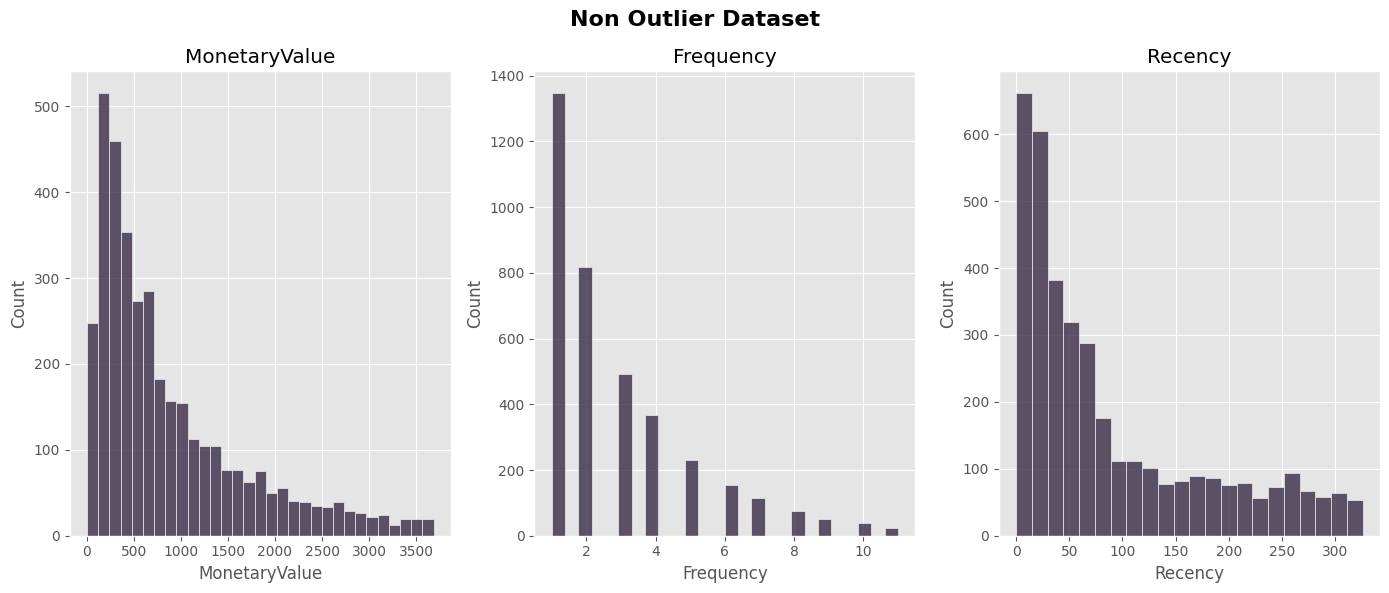

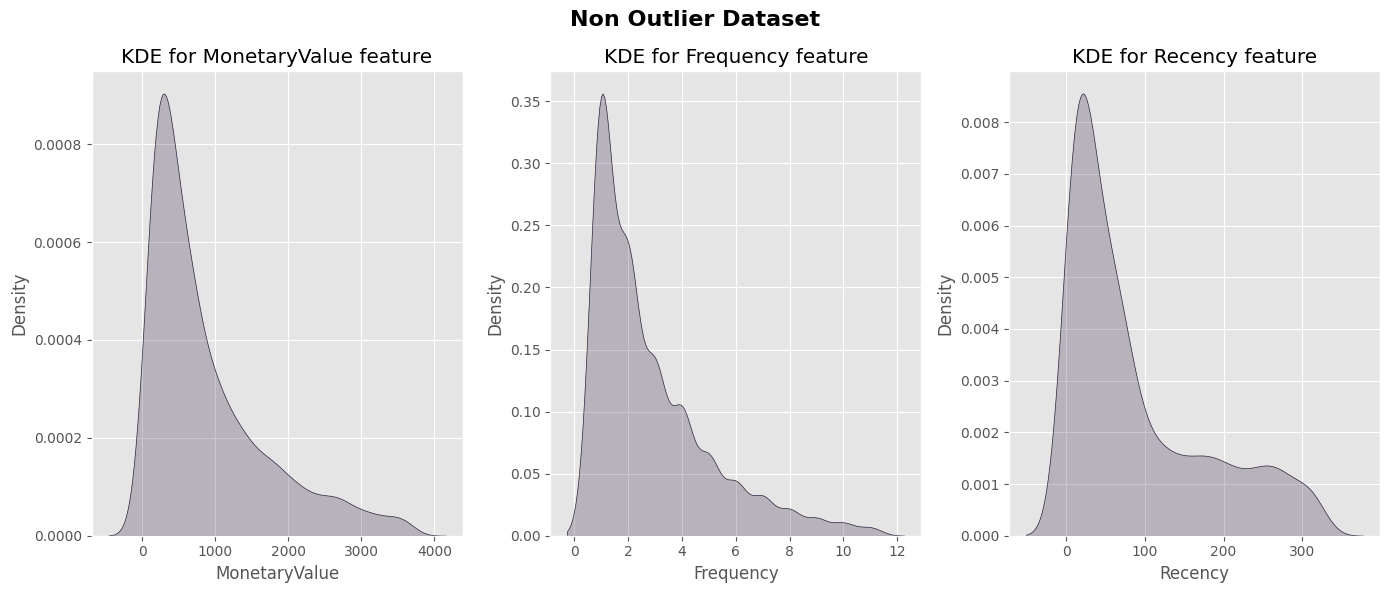

In [202]:
def distributionHistoplot(dataframe: pd.DataFrame, title: str):
    plt.figure(figsize=(14, 6))
    for i, column in enumerate(dataframe.drop(columns=['CustomerID', 'LastInvoiceDate'])):
        plt.subplot(1, 3, i+1)
        sns.histplot(dataframe[column])
        plt.title(f'{column}')
        plt.suptitle(title, fontsize=16, weight='bold')


    plt.tight_layout()
    plt.show()

# Feature distribution
distributionHistoplot(non_outlier_df, 'Non Outlier Dataset')
distributionBell(non_outlier_df, 'Non Outlier Dataset')

In [203]:
def statistics(dataframe: pd.DataFrame):
    for column in dataframe.drop(columns=['CustomerID', 'LastInvoiceDate']):
        _skew = skew(dataframe[column])
        _kurtosis = kurtosis(dataframe[column], fisher=True)
        print(
            f"\n{column}\n"
            f"skew: {_skew:.4f}\n"
            f"kurtosis: {_kurtosis:.4f}"
        )

        # Perform Shapiro-Wilk test
        stat, p_value = shapiro(dataframe[column])

        # Print the results
        print(f"Shapiro-Wilk Test Statistic: {stat:.4f}")
        print(f"P-value: {p_value:.4f}")

        # Interpret the p-value
        alpha = 0.05
        if p_value > alpha:
            print("The data is likely normally distributed (fail to reject H0).")
        else:
            print("The data is not normally distributed (reject H0).")

        # Check the absolute values of each skew value of a feature
        if np.abs(_skew) < 0.5:
            print('distribution is almost symmetrical')
        elif 0.5 <= np.abs(_skew) <= 1:
            print('distribution is modertely skewed')
        else:
            print('distribution is highly skewed')
        
        # Extremity of tail distribution
        if _kurtosis > 0:
            print(
                f'Leptokurtic distribution - heavier tails and a sharper peak than the '
                f'normal distribution.\n'
                f'This type of distribution is often associated with higher peakedness '
                f'and a greater probability of extreme values.\n'
            )
        elif _kurtosis < 0:
            print(
                f'Platykurtic distribution - lighter tails and a flatter peak than the '
                f'normal distribution.\n'
                f'This type of distribution is often associated with less peakedness ' 
                f'and a lower probability of extreme values.\n'
            )
        else:
            print(
                f'Mesokurtic distribution - similar peak and tail shape as the normal '
                f'distribution.\n'
                )

In [204]:
statistics(non_outlier_df)


MonetaryValue
skew: 1.3993
kurtosis: 1.3391
Shapiro-Wilk Test Statistic: 0.8382
P-value: 0.0000
The data is not normally distributed (reject H0).
distribution is highly skewed
Leptokurtic distribution - heavier tails and a sharper peak than the normal distribution.
This type of distribution is often associated with higher peakedness and a greater probability of extreme values.


Frequency
skew: 1.4695
kurtosis: 1.8077
Shapiro-Wilk Test Statistic: 0.8031
P-value: 0.0000
The data is not normally distributed (reject H0).
distribution is highly skewed
Leptokurtic distribution - heavier tails and a sharper peak than the normal distribution.
This type of distribution is often associated with higher peakedness and a greater probability of extreme values.


Recency
skew: 1.0934
kurtosis: 0.0023
Shapiro-Wilk Test Statistic: 0.8398
P-value: 0.0000
The data is not normally distributed (reject H0).
distribution is highly skewed
Leptokurtic distribution - heavier tails and a sharper peak than the 

`NOTES`:

* Based on the distribution plots of the three freature MonetaryValue, Frequency and Recency, we can see that all the features are positively skewed. 

* Using hypothesis testing, the null hypothesis is assumed that the feature is normally distributed, whilst the alternative hypothesis rejects this assumption, which  in this case would mean that the feature values are not normally distributed. Selecting the alpha value as 5%, and determining the p_value by performing the Shapiro-Wilk test, we can compare the p_value to the alpha value, and where the p_value is greater than the alpha value, we can infer that the null hypothesis has failed to be rejected, making the distribution of the feature normal. 

* If the skewness is lower than -1 (negatively skewed) or greater than 1 (positively skewed), the data is highly skewed. (Menon, 2024)

* Looking at the skew values of each feature, we can see that the features are also highly skewed, and having all the features positively skewed, this would mean that the post ideal scaling method would be to log transform the features of the non_outlier_df.

## **Feature Scaling**
___
Feature scaling is the process of transforming the values of numerical features in a dataset so that they share a common scale, without distorting differences in the ranges of values. This ensures that no single feature disproportionately influences a machine learning model, particularly for models sensitive to the magnitude of input features.

In [205]:
non_outlier_df.head(1)

,CustomerID,MonetaryValue,Frequency,LastInvoiceDate,Recency
2,12348.0,1797.24,4,2011-09-25 13:13:00,74


In [206]:
# Scale the MonetaryValue, Frequency and Recency features and store as a datafrae
log_scaled_df = np.log1p(non_outlier_df.loc[:, ['MonetaryValue', 'Frequency', 'Recency']])

# Set the index as the CustomerID feature from the non_outlier_df
log_scaled_df.index = non_outlier_df['CustomerID']
log_scaled_df

,MonetaryValue,Frequency,Recency
CustomerID,,,
12348.0,7.494564,1.609438,4.317488
12349.0,7.472245,0.693147,2.944439
12350.0,5.815324,0.693147,5.736572
12352.0,7.826858,2.197225,3.583519
12353.0,4.499810,0.693147,5.318120
...,...,...,...
18278.0,5.164214,0.693147,4.304065
18280.0,5.201806,0.693147,5.627621
18281.0,4.404522,0.693147,5.198497


## **Clustering**
___
Clustering is an unsupervised learning technique used in machine learning and data analysis to group data points into clusters based on their behavioural similarities.

#### 1. **Finding K**
In this section we look for the optimal number of clusters for the dataset.

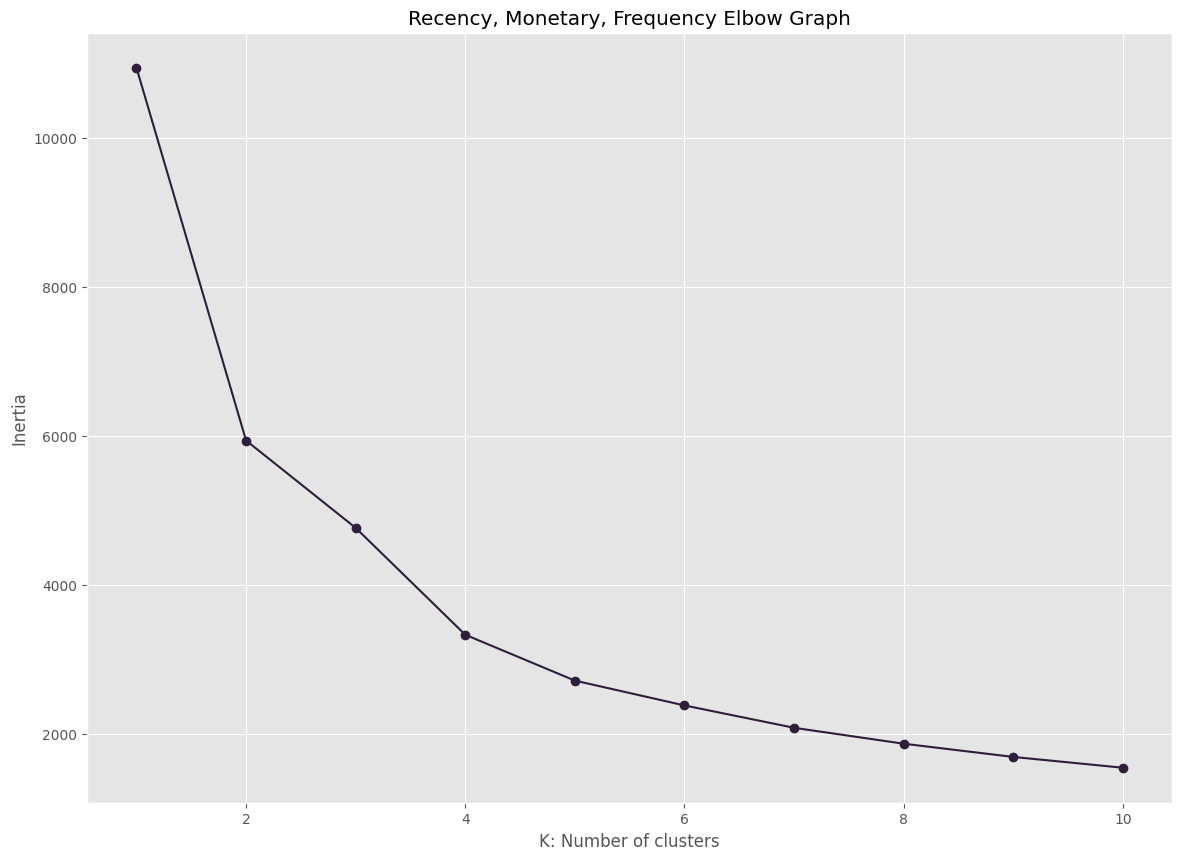

In [207]:
def eval_Kmeans(X, k, r):
    kmeans = KMeans(n_clusters=k, random_state=r)
    kmeans.fit(X)    
    return kmeans.inertia_

def elbow_Kmeans(X, dataset: str, max_k=10, r=123):
    within_cluster_vars = [eval_Kmeans(X, k, r) for k in range(1, max_k+1)]
    plt.plot(range(1, 11), within_cluster_vars,marker='o')
    plt.xlabel('K: Number of clusters')
    plt.ylabel('Inertia')
    plt.title(f'{dataset} Elbow Graph')
    plt.grid(True)

plt.figure(figsize=(14, 10))
plt.subplot()
elbow_Kmeans(log_scaled_df, dataset='Recency, Monetary, Frequency')

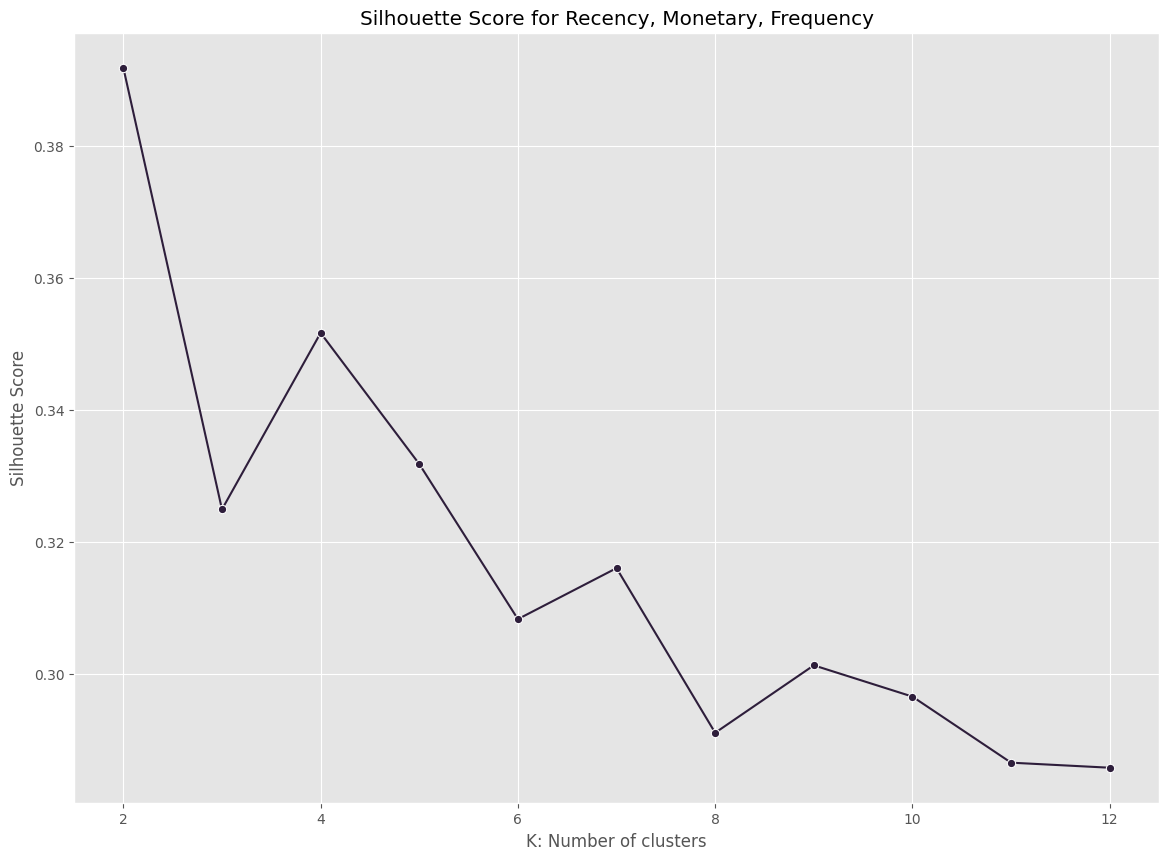

In [208]:
def silhouetteScore(dataframe: pd.DataFrame, dataset: str) -> None:
    # Silhouette score method
    kmax = 12
    sil = []
    plt.plot()
    for k in range(2, kmax+1,):
        kmeans = KMeans(n_clusters=k, random_state=42, max_iter=1000)
        kmeans.fit(dataframe)
        labels = kmeans.labels_
        sil.append(silhouette_score(dataframe, labels, metric='euclidean'))

    sns.lineplot(x=range(2, kmax+1), y=sil, marker='o')
    plt.title(f'Silhouette Score for {dataset}')
    plt.xlabel('K: Number of clusters')
    plt.ylabel(f"Silhouette Score")
    plt.grid(True)

plt.figure(figsize=(14, 10))
plt.subplot()
silhouetteScore(log_scaled_df, dataset='Recency, Monetary, Frequency')

`NOTES`:

* The Elbow graph (or Elbow method) is used in k-means clustering to find the optimal number of clusters. It helps identify the point of diminishing returns, where adding more clusters beyond that point doesn't significantly reduce the within-cluster variance (or improve the model). This "elbow point" indicates the number of clusters where further increases would yield little to no improvement, making it an optimal choice for the clustering process.

* Based on the Elbow graph, we can see that the point of diminishing returns can be found between 3 to 5 clusters. To ascertain which is the optimal number of clusters to use, we also find the silhouette scores of these clusters and select the number of clusters with the highest silhouette scores. 

* In our case, we can see that the optimal number of clusters would be 4. 

#### 2. **Finding Clusters**
This process involves predicting the clusters using the selected number of clusters from the previous phase. 

In [209]:
non_outlier_df.head()

,CustomerID,MonetaryValue,Frequency,LastInvoiceDate,Recency
2,12348.0,1797.24,4,2011-09-25 13:13:00,74
3,12349.0,1757.55,1,2011-11-21 09:51:00,18
4,12350.0,334.40,1,2011-02-02 16:01:00,309
5,12352.0,2506.04,8,2011-11-03 14:37:00,35
6,12353.0,89.00,1,2011-05-19 17:47:00,203


In [210]:
# Predict clusters for non-outlier dataset
k = 4
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
cluster_labels_ = kmeans.fit_predict(log_scaled_df)
non_outlier_df['Cluster'] = cluster_labels_

non_outlier_df.head()

,CustomerID,MonetaryValue,Frequency,LastInvoiceDate,Recency,Cluster
2,12348.0,1797.24,4,2011-09-25 13:13:00,74,2
3,12349.0,1757.55,1,2011-11-21 09:51:00,18,2
4,12350.0,334.40,1,2011-02-02 16:01:00,309,3
5,12352.0,2506.04,8,2011-11-03 14:37:00,35,2
6,12353.0,89.00,1,2011-05-19 17:47:00,203,3


#### 3. **Clustering outlier_df**
In this section, we will be clustering the outlier values, using venn diagrams. 

In [211]:
aggregated_df.head()

,CustomerID,MonetaryValue,Frequency,LastInvoiceDate,Recency
0,12346.0,77183.60,1,2011-01-18 10:01:00,325
1,12347.0,4310.00,7,2011-12-07 15:52:00,1
2,12348.0,1797.24,4,2011-09-25 13:13:00,74
3,12349.0,1757.55,1,2011-11-21 09:51:00,18
4,12350.0,334.40,1,2011-02-02 16:01:00,309


In [212]:
# Store a dataframe for the MonertaryValue outlier values 
dataframe_subset = aggregated_df.select_dtypes(exclude='datetime64').drop(columns='CustomerID')
MonetaryValueOutlier_df = outlierIQR('MonetaryValue', False, True, dataframe_subset)

# Store a dataframe for the Recency outlier values 
RecencyOutlier_df = outlierIQR('Recency', False, True, dataframe_subset)

# Store a dataframe for the Frequency outlier values 
FrequencyOutlier_df = outlierIQR('Frequency', False, True, dataframe_subset)

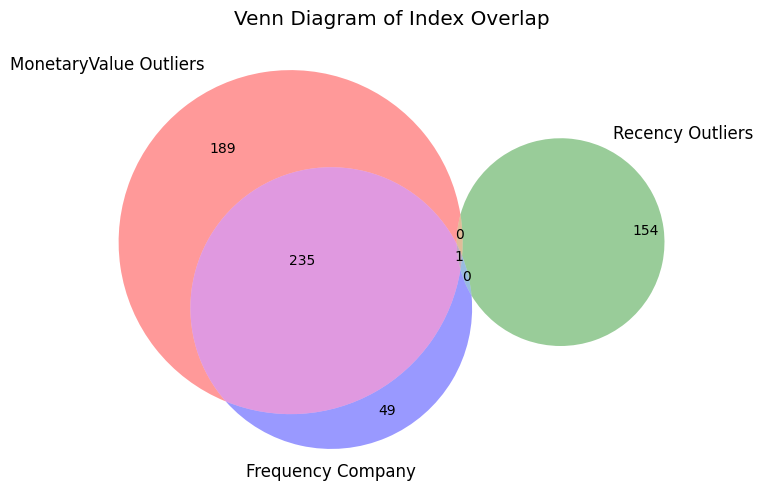

In [213]:
# Extracting the index sets from the DataFrames
set1 = set(MonetaryValueOutlier_df.index)
set2 = set(RecencyOutlier_df.index)
set3 = set(FrequencyOutlier_df.index)

# Create a Venn diagram using the index sets
plt.figure(figsize=(8, 8))
venn = venn3([set1, set2, set3], ('MonetaryValue Outliers', 'Recency Outliers', 'Frequency Company'))

# Display the Venn diagram
plt.title("Venn Diagram of Index Overlap")
plt.show()


In [214]:
all_int_indexes = (set1.intersection(set2)).intersection(set3)
MonetaryValue_AND_Frequency_indexes = (set1.intersection(set3)).difference(all_int_indexes)
MonetaryValue_AND_Recency_indexes = (set1.intersection(set2)).difference(all_int_indexes)
Recency_AND_Frequency_indexes = (set2.intersection(set3)).difference(all_int_indexes)
Frequency_ONLY_index = (set3.difference(set2)).difference(set1)
MonetaryValue_ONLY_index = (set1.difference(set2)).difference(set3)
Recency_ONLY_index = (set2.difference(set1)).difference(set3)

# Confirm that the total indexes per variable match the Venn Diagram totals
print(
    f'Intersect group: {len(all_int_indexes)}\n'
    f'MonetaryValue and Frequency group: {len(MonetaryValue_AND_Frequency_indexes)}\n'
    f'MonetaryValue and Recency group: {len(MonetaryValue_AND_Recency_indexes)}\n'
    f'Recency and Frequency group: {len(Recency_AND_Frequency_indexes)}\n'
    f'Frequency group: {len(Frequency_ONLY_index)}\n'
    f'MonetaryValue group: {len(MonetaryValue_ONLY_index)}\n'
    f'Recency group: {len(Recency_ONLY_index)}\n'
)

# Set Cluster column for outlier df as None
outlier_df['Cluster'] = None

# Manually add the cluster names from the outliers
outlier_df.loc[list(all_int_indexes), 'Cluster'] = 4
outlier_df.loc[list(MonetaryValue_AND_Frequency_indexes), 'Cluster'] = 5
outlier_df.loc[list(Frequency_ONLY_index), 'Cluster'] = 6
outlier_df.loc[list(MonetaryValue_ONLY_index), 'Cluster'] = 7
outlier_df.loc[list(Recency_ONLY_index), 'Cluster'] = 8

Intersect group: 1
MonetaryValue and Frequency group: 235
MonetaryValue and Recency group: 0
Recency and Frequency group: 0
Frequency group: 49
MonetaryValue group: 189
Recency group: 154



## **Cluster Analysis**
___
In this section, we will look to perform an EDA on the clusters we have created.

In [215]:
outlier_df.head()

,CustomerID,MonetaryValue,Frequency,LastInvoiceDate,Recency,Cluster
0,12346.0,77183.60,1,2011-01-18 10:01:00,325,7
1,12347.0,4310.00,7,2011-12-07 15:52:00,1,7
10,12357.0,6207.67,1,2011-11-06 16:07:00,32,7
12,12359.0,6310.03,4,2011-10-13 12:47:00,57,7
15,12362.0,5226.23,10,2011-12-06 15:40:00,2,7


In [216]:
non_outlier_df.head()

,CustomerID,MonetaryValue,Frequency,LastInvoiceDate,Recency,Cluster
2,12348.0,1797.24,4,2011-09-25 13:13:00,74,2
3,12349.0,1757.55,1,2011-11-21 09:51:00,18,2
4,12350.0,334.40,1,2011-02-02 16:01:00,309,3
5,12352.0,2506.04,8,2011-11-03 14:37:00,35,2
6,12353.0,89.00,1,2011-05-19 17:47:00,203,3


In [217]:
# Concatenate the non_outlier_df and the cluster_outlier_df
clustered_df = pd.concat([non_outlier_df, outlier_df], axis=0)
clustered_df

,CustomerID,MonetaryValue,Frequency,LastInvoiceDate,Recency,Cluster
2,12348.0,1797.24,4,2011-09-25 13:13:00,74,2
3,12349.0,1757.55,1,2011-11-21 09:51:00,18,2
4,12350.0,334.40,1,2011-02-02 16:01:00,309,3
5,12352.0,2506.04,8,2011-11-03 14:37:00,35,2
6,12353.0,89.00,1,2011-05-19 17:47:00,203,3
...,...,...,...,...,...,...
4205,18106.0,421.90,1,2011-01-14 12:23:00,329,8
4210,18113.0,76.32,1,2010-12-06 12:31:00,368,8
4215,18119.0,180.70,1,2010-12-07 11:59:00,367,8
4256,18176.0,476.35,1,2010-12-16 15:45:00,357,8


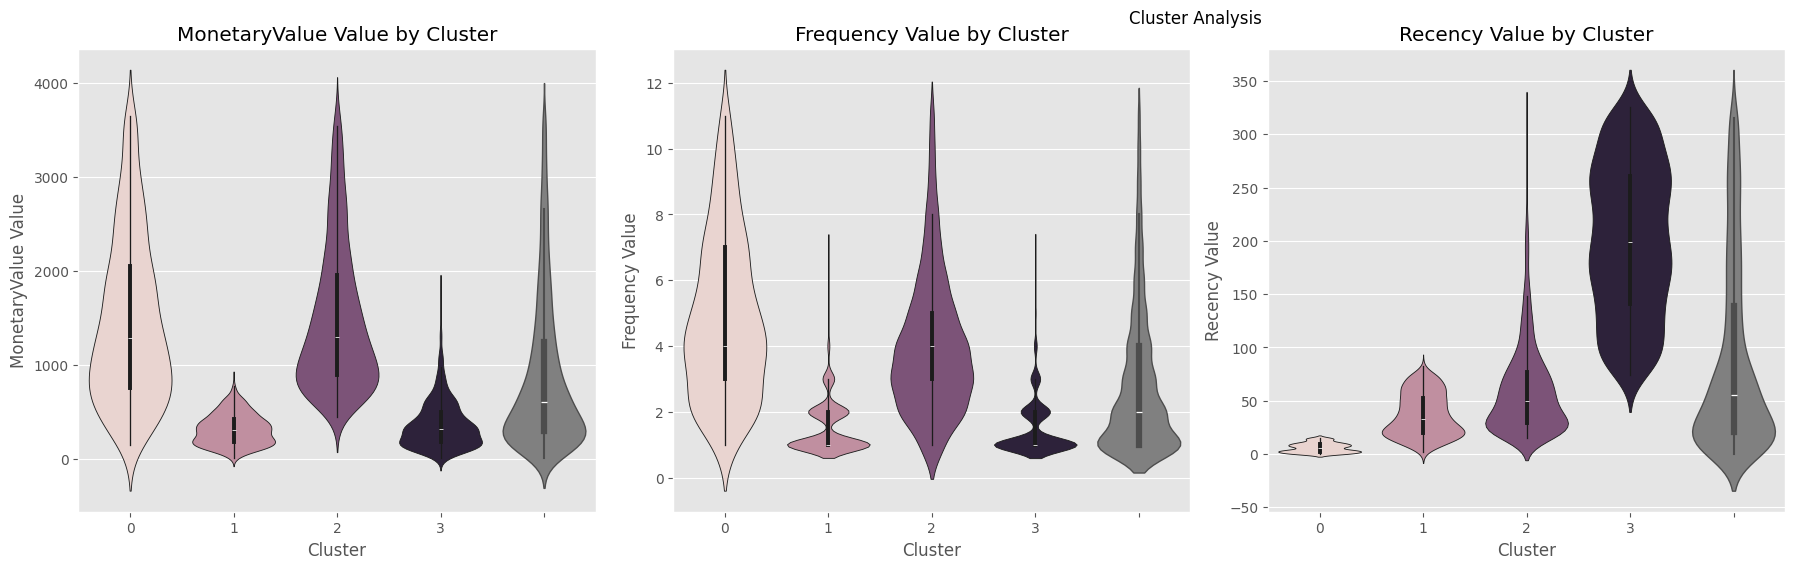

In [218]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def violinPlot(dataframe: pd.DataFrame):
    plt.figure(figsize=(24, 16))

    for i, column in enumerate(dataframe.drop(columns=['CustomerID', 'LastInvoiceDate', 'Cluster'])):
        plt.subplot(3, 4, 1 + i)
        sns.violinplot(x=dataframe['Cluster'], y=dataframe[column], hue=dataframe['Cluster'], legend=False)
        sns.violinplot(y=dataframe[column], palette='gray', linewidth=1.0)
        plt.title(f'{column} Value by Cluster')
        plt.ylabel(f'{column} Value')

    plt.suptitle('Cluster Analysis')
    plt.tight_layout()
    plt.show()

violinPlot(non_outlier_df)

In [219]:
non_outlier_df[non_outlier_df['Cluster'] == 0].Recency.median()

np.float64(6.0)

#### `CLUSTER CLASSIFICATION`:

**Cluster 0**:
* *Descriptions* 
    * *MonetaryValue* The median value of this cluster is between £1200 and £1300. This is compared to the average median value for the non-outlier customers, which is between £600 - £650. 

    * *Frequency* The median value of the feature with no outliers is approximately 2, compared to the frequency of this cluster, which is twice that of the entire feature, at 4. This identifies thic cluster as a high frequency cluster.

    * *Recency* The median value of the cluster is 6. 

* *Classification*
    * New High-value, Engaged Customer

**Cluster 1**:
* *Descriptions* 
    * *MonetaryValue* The median value of this cluster can be found at around £325.00, which would be significantly less than that of the average customer median value, of around £600.00 - £650.00. This identifies the customers in this cluster as low-value customers. 

    * *Frequency* The median value for frequency for this cluster is 1, which is at least half of the median of this feature for all customers who aren't outliers. This suggests that these are new customers with single purchases only. 

    * *Recency* The recency median value of this cluster is approximately 35 days, which is less than the median of all the non-outlier customers, which is around 52 days. This suggests that the customers in this cluster have recently made their first purchases. 

* *Classification*
    * New Customer.

**Cluster 2**:
* *Descriptions* 
    * *MonetaryValue* The median value of this cluster is between £1250.00 and £1350.00, which is above the median value of the feature for the customers that aren't outliers. The median value of the feature for these customers falls between £600.00 to £650.00. That would identify these customers as high-value customers that spend more on average.

    * *Frequency* The median value of this cluster is 4 for frequency, which is twice that of all the customers that arent outliers, which is a frequency of 2. This suggests that these are repeated customers.

    * *Recency* The recency of this cluster mirrors that of the entire feature for all customers that are not outliers, which is approximately 50 days. 

* *Classification*
    * High-Value, Interested Customer

**Cluster 3**:
* *Descriptions* 
    * *MonetaryValue* The median value of this cluster can be found at around £325.00, which would be significantly less than that of the average customer median value, of around £600.00 - £650.00. This identifies the customers in this cluster as low-value customers. 

    * *Frequency* The median value for frequency for this cluster is 1, which is at least half of the median of this feature for all customers who aren't outliers. This suggests a new buyer, or a once off customer. 

    * *Recency* The median value of this cluster is 200 days, which is 4x that of the median value of the feature for all the customers that aren't outliers. This suggests that the buyer was a once-off customer. 

* *Classification*
    * Once-Off customer.

**Cluster Summary**
| Cluster | Description | Classification | 
| ------- | ----------- | -------------- |
| 0 | Large spenders, spend frequently and very recently | New High-value, Engaged Customer |
| 1 | Low spenders, with low frequency and recency | New Customer |
| 2 | Large spenders, frequnt spender, Average recency | High-Value, Interested Customer |
| 3 | Low spenders, infrequent, long recency period | Once-Off Customer |

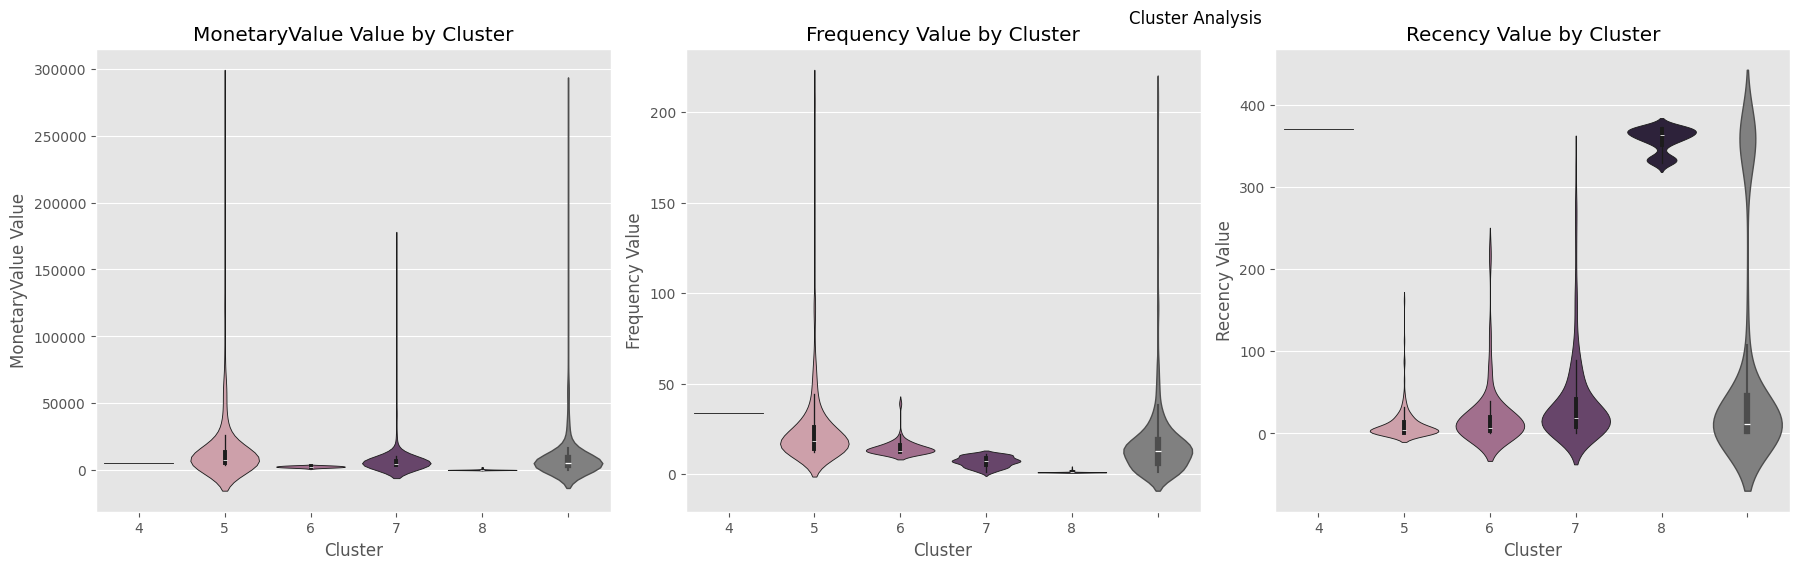

In [220]:
violinPlot(outlier_df)

#### `OUTLIER CLUSTER CLASSIFICATION`:

**Cluster 4**:
* *Descriptions* 
    * *MonetaryValue* There arent a lot of customers in this cluster as we can see with the dispersion size of the boxplot. However, the median value of this cluster is similar to the median value of all the customers that are outliers. These are high value customers. The median values can be found between £5100.00 - £5500.00. 

    * *Frequency* This clusters median for frequency is greater than that of the feature for all customers that are outliers (13). The clusters frequency can be found between 30 to 35, which is more than double of the features median value. 

    * *Recency* The median value of the cluster is 371, compared to that of the entire features for all outlier customers, which is 13.

* *Classification*
    * Lapsed Customers


**Cluster 5**:
* *Descriptions* 
    * *MonetaryValue* The median value of this cluster is similar to the median value of all the customers that are outliers. These are high value customers. The median values can be found between £5100.00 - £5500.00. 

    * *Frequency* This clusters median for frequency is greater than that of the feature for all customers that are outliers (13). The clusters frequency can be found between 15 to 20. This suggests that these customers are frequent customers.

    * *Recency* Customers within this cluster have a recency value of 4, compared to the median of the entire feature for all outliers, which is 11. This suggests customers in this cluster are active customers

* *Classification*
    * Active, High-value Customer.


**Cluster 6**:
* *Descriptions* 
    * *MonetaryValue* The customers of this cluster have a lower mean value to that of the mean of the outlier customers, The median value of this cluster can be found within the £2500.00 - £2800.00 range. So even though relatively these are love value customers compared to the rest of the outlier clusters, but overall, these are comparatively higher value customers. 

    * *Frequency* Customers in this cluster have a frequency median value that is 13, which is exactly the same as the median value of the feature for all outlier customers. This suggests these customers are frequent customers.

    * *Recency* Customers within this cluster have a similar median value as the median recency of the outlier customers. The median value for this cluster is 7, while the feature median value for all outlier customers is 11. This suggests customers in this cluster are active customers

* *Classification*
    * Active, Moderate-value Customer. 


**Cluster 7**:
* *Descriptions*
    * *MonetaryValue* The median value of this cluster is similar to the median value of all the customers that are outliers. These are high value customers. The median values can be found between £4800.00 - £5000.00. This suggests that the customers in this cluster are moderate spenders

    * *Frequency* Customers in this cluster have a lower frequency median compared to the frequency median of the outlier customers. The median value of this cluster is 7, compared to that of the feature, 13. Active customers.

    * *Recency* For this outlier cluster is 19, which is higher than that of the entire feature for outlier customers (11). This suggests a disengaged customer.

* *Classification*
    * Disengaged Customer.

**Cluster 8**:
* *Descriptions* 
    * *MonetaryValue* Customers in this class are low spenders, and their median spending can be seen between £200 - £250, compared to the outlier customers median value of approximately £5100.00 - £5500.00.

    * *Frequency* Customers in this cluster have a lower frequency median, with a value of 1. This suggests that customers in this category are once off spenders

    * *Recency* Customers within this cluster have a median recency value of 363. Lapsed client

* *Classification*
    * Lapsed Once-off Customer


**Cluster Summary**
| Cluster | Description | Classification | 
| ------- | ----------- | -------------- |
| 4 | High spenders, Frequent and Lapsed | Lapsed Customer |
| 5 | High spenders, Frequent and Active | Active, High-value Customer |
| 6 | Moderate spenders, Infrequent and Inactive | Active, Moderate-value Customer |
| 7 | Moderate spenders, infrequent, Sparse | Disengaged Customers |
| 8 | Low spenders, infrequent, Inactive | Lapsed Once-off Customer |

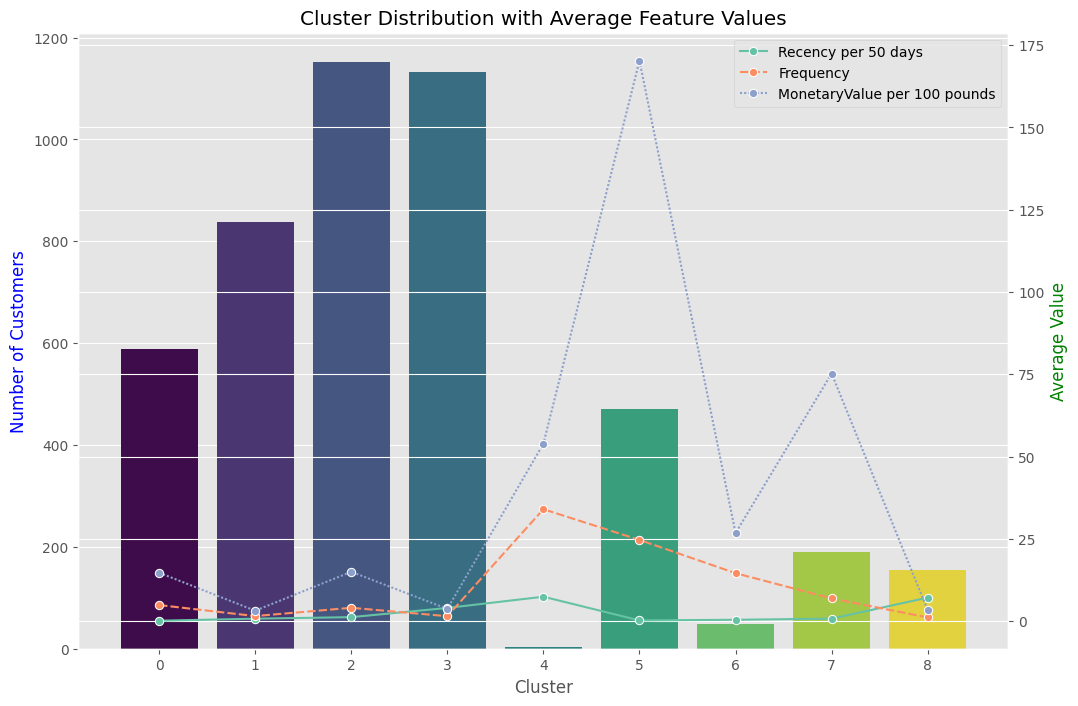

In [221]:
cluster_counts = clustered_df['Cluster'].value_counts()
clustered_df["MonetaryValue per 100 pounds"] = clustered_df["MonetaryValue"] / 100
clustered_df["Recency per 50 days"] = clustered_df["Recency"] / 50
feature_means = clustered_df.groupby('Cluster')[['Recency per 50 days', 'Frequency', 'MonetaryValue per 100 pounds']].mean()

fig, ax1 = plt.subplots(figsize=(12, 8))

sns.barplot(x=cluster_counts.index, y=cluster_counts.values, ax=ax1, palette='viridis', hue=cluster_counts.index)
ax1.set_ylabel('Number of Customers', color='b')
ax1.set_title('Cluster Distribution with Average Feature Values')
ax1.legend_.remove()

ax2 = ax1.twinx()

sns.lineplot(data=feature_means, ax=ax2, palette='Set2', marker='o')
ax2.set_ylabel('Average Value', color='g')

plt.show()

In [222]:
# Store the mapping of the clusters
classification_map = {
    0: 'New High-value, Engaged Customer',
    1: 'New Customer',
    2: 'High-Value, Interested Customer',
    3: 'Once-Off Customer',
    4: 'Lapsed, High-value Customer',
    5: 'Active, High-value Customer',
    6: 'Active, Moderate-value Customer',
    7: 'Disengaged Customers',
    8: 'Lapsed Once-off Customer'
}

# Set the cluster map on the cluster feature
clustered_df['Cluster'] = clustered_df['Cluster'].map(classification_map)
clustered_df.head()

,CustomerID,MonetaryValue,Frequency,LastInvoiceDate,Recency,Cluster,MonetaryValue per 100 pounds,Recency per 50 days
2,12348.0,1797.24,4,2011-09-25 13:13:00,74,"High-Value, Interested Customer",17.9724,1.48
3,12349.0,1757.55,1,2011-11-21 09:51:00,18,"High-Value, Interested Customer",17.5755,0.36
4,12350.0,334.40,1,2011-02-02 16:01:00,309,Once-Off Customer,3.3440,6.18
5,12352.0,2506.04,8,2011-11-03 14:37:00,35,"High-Value, Interested Customer",25.0604,0.70
6,12353.0,89.00,1,2011-05-19 17:47:00,203,Once-Off Customer,0.8900,4.06


## **Bibliography**
___

1. Optimove (no date) _RMF Segmentation_. Available at: https://www.optimove.com/resources/learning-center/rfm-segmentation#:~:text=RFM%20segmentation%20is%20a%20marketing,targeted%20and%20personalized%20marketing%20strategies. (Accessed: 27 September 2024)

2. Menon, K. (2024) _The Complete Guide to Skewness and Kurtosis_. Available at:https://www.simplilearn.com/tutorials/statistics-tutorial/skewness-and-kurtosis#:~:text=%2D1%20and%20%2D0.5%2C%20the,the%20data%20is%20highly%20skewed. (Accessed: 28 September 2024)